In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 讀入套件

In [2]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 下載資料集

In [3]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

## 資料處理

In [4]:
# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

## 建立VAE
### 修改參數:
#### encoder和decoder各增加2層，並修改各層參數
#### 部分使用relu作為激發函數

In [5]:
enc_1 = Dense(128, activation='sigmoid')
enc_2 = Dense(256, activation='relu')
enc_3 = Dense(484, activation='relu')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_4 = Dense(196, activation='relu')
dec_3 = Dense(100, activation='sigmoid')
dec_2 = Dense(128, activation='relu')
dec_1 = Dense(784, activation='sigmoid')

In [6]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

## 定義抽樣函數

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon 

## 轉成Keras layer

In [8]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

## 定義decorder

In [9]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(dec_4(z_input))))

## Summary

In [10]:
x_hat = dec_1(dec_2(dec_3(dec_4(z))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          33024       dense[0][0]                      
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
______________________________________________________________________________________________

## 建立損失函數

In [11]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

## 訓練

In [12]:
VAE.compile(optimizer=Adam())

In [13]:
VAE.fit(X_train, 
        batch_size=256,       # 改變batch_size為256
        epochs=15)            # 訓練次數改為15次

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 89us/sample - loss: 59.4179
Epoch 2/15
60000/60000 [==============================] - 4s 63us/sample - loss: 49.5467
Epoch 3/15
60000/60000 [==============================] - 4s 66us/sample - loss: 47.5035
Epoch 4/15
60000/60000 [==============================] - 4s 68us/sample - loss: 46.5522
Epoch 5/15
60000/60000 [==============================] - 4s 63us/sample - loss: 44.8810
Epoch 6/15
60000/60000 [==============================] - 4s 70us/sample - loss: 43.3329
Epoch 7/15
60000/60000 [==============================] - 4s 64us/sample - loss: 42.2275
Epoch 8/15
60000/60000 [==============================] - 4s 67us/sample - loss: 41.2526
Epoch 9/15
60000/60000 [==============================] - 4s 66us/sample - loss: 40.4485
Epoch 10/15
60000/60000 [==============================] - 4s 64us/sample - loss: 39.9438
Epoch 11/15
60000/60000 [==============================] - 4s 64us/sample - loss: 39.5

## VAE視覺化呈現

In [14]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 134,018
Trainable params: 134,018
Non-trainable params: 0
_________________________________________________________________


In [15]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(dec_4(z_input)))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 196)               588       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               19700     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 134,352
Trainable params: 134,352
Non-trainable params: 0
_________________________________________________________________


In [17]:
indices = np.random.randint(X_train.shape[0], size=3456) 
VAE_latents = VAE_Encoder.predict(X_train[indices])

#### 圖表大小設為(15, 12) 
#### 顏色採用viridis

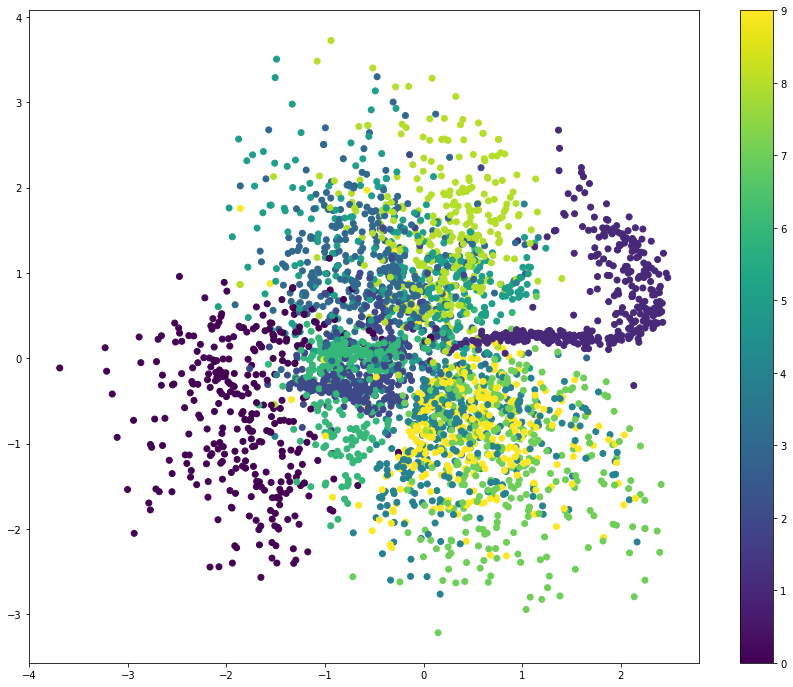

In [20]:
plt.figure(figsize=(15, 12))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='viridis')
plt.colorbar()
plt.show()

## decorder的視覺化 

In [21]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [22]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [23]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

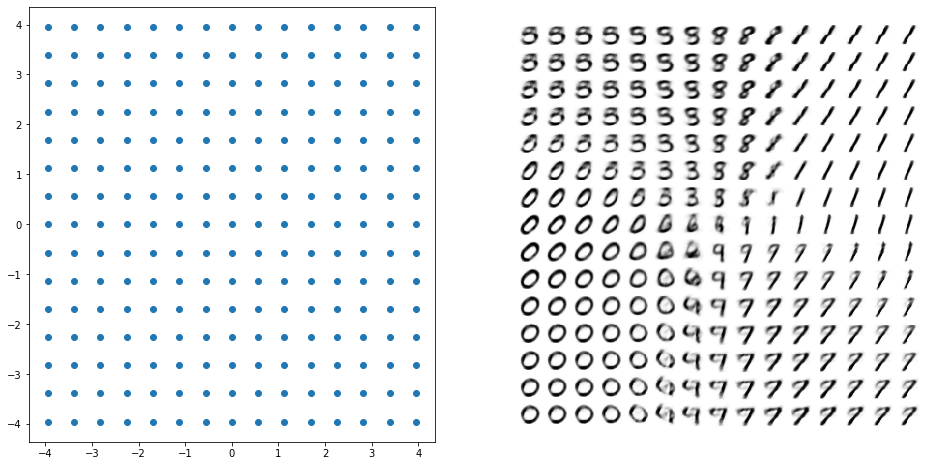

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 動態比較

In [25]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [26]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [27]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>